## chainerによる深層学習 - 手書き数字認識

* chainerについて
    - https://chainer.org

### Install
`$ pip3 install chainer`

### Reference
* https://docs.chainer.org/en/stable/examples/mnist.html
    - このnotebookはほとんどこのexampleを使ってます．
* https://docs.chainer.org/en/stable/examples/index.html
    - CNNなど，他のネットワークなどの例もいくつか載っています．


* https://qiita.com/mitmul/items/1e35fba085eb07a92560
    - PFNの人が書いてる「ビギナー向けチュートリアル」．めっちゃ詳しい．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import chainer
from chainer import backend
from chainer import backends
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
from chainer.training import extensions
from chainer.datasets import mnist
from chainer.dataset import concat_examples
from chainer.backends import cuda
from chainer.backends.cuda import to_cpu
import chainer.functions as F
import chainer.links as L

/Users/kevin/python-venv/def/lib/python3.7/site-packages/chainer/_environment_check.py:37: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Please be aware that Mac OS X is not an officially supported OS.

  ''')  # NOQA


## 1. Prepare a dataset

In [2]:
# Download the MNIST data if you haven't downloaded it yet
train, test = mnist.get_mnist(withlabel=True, ndim=1)

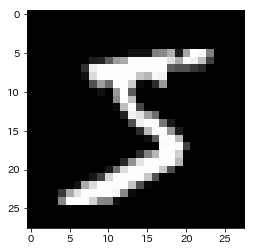

label: 5


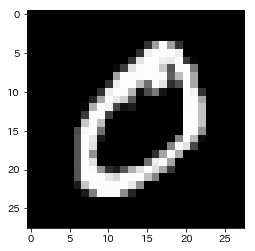

label: 0


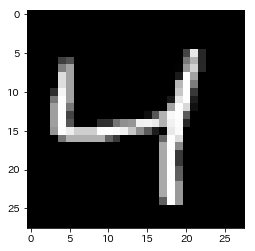

label: 4


In [3]:
# Display an example from the MNIST dataset.
# `x` contains the input image array and `t` contains that target class
# label as an integer.
for i in range(3):
    x, t = train[i]
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.show()
    print('label:', t)

## 2. Create a dataset iterator

In [4]:
# Choose the minibatch size.
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

## 3. Define a network

In [5]:
class MLP(Chain):
    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(None, n_mid_units)
            self.l3 = L.Linear(None, n_out)

    def forward(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

model = MLP()

#gpu_id = 0  # Set to -1 if you use CPU
gpu_id = -1
if gpu_id >= 0:
    model.to_gpu(gpu_id)

## 4. Prepare the Updater

In [6]:
max_epoch = 10

# Wrap your model by Classifier and include the process of loss calculation within your model.
# Since we do not specify a loss function here, the default 'softmax_cross_entropy' is used.
model = L.Classifier(model)

# selection of your optimizing method
optimizer = optimizers.MomentumSGD()

# Give the optimizer a reference to the model
optimizer.setup(model)

# Get an updater that uses the Iterator and Optimizer
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)

## 5. Setup Trainer

In [7]:
# Setup a Trainer
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')

## 6. Perform classification by the saved model

In [8]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

## 7. Start Training

In [9]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.542104    0.846015       0.252184              0.92682                   1.57342       
2           0.226304    0.934335       0.184861              0.946005                  3.53679       
3           0.168278    0.951326       0.144215              0.957278                  5.48114       
4           0.135514    0.96072        0.127128              0.962322                  7.51774       
5           0.11315     0.967001       0.111258              0.965783                  9.52244       
6           0.0973445   0.971665       0.0990416             0.96964                   11.4484       
7           0.0855073   0.974847       0.0992585             0.969739                  13.3833       
8           0.0758054   0.977648       0.0957607             0.971123                  15.4078       
9           0.0665533   0.980394       0.0861953             0.972508               

`notebook/mnist_result/`の中に，accuracyやlossのグラフなどが入っています．

`notebook/mnist_result/accuracy.png`
<img src="mnist_result/accuracy.png" width="500">

`notebook/mnist_result/loss.png`
<img src="mnist_result/loss.png" width="500">

## 8. Evaluate a pre-trained model

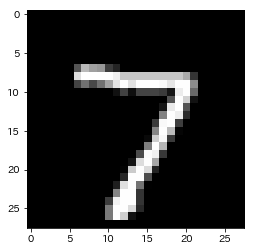

label: 7
predicted_label: 7


In [10]:
model = MLP()
serializers.load_npz('mnist_result/model_epoch-10', model)

# Show the output
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

y = model(x[None, ...])

print('predicted_label:', y.array.argmax(axis=1)[0])

In [16]:
x.shape, x[None, ...].shape

((784,), (1, 784))

In [14]:
model(x[None, ...])

variable([[ -0.94007415,  -0.56970274,   5.4660873 ,   4.848766  ,
            -4.6261907 ,  -2.1350842 , -11.73201   ,  12.34142   ,
            -0.7088871 ,   2.1742349 ]])

## 9. Check miss-predicted images
predictionをミスった画像を見てみると，「人が見ても間違えそうだな〜」というものが多いかも(?)

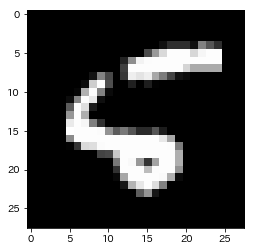

label: 5
predicted label: 6

----------------------------------



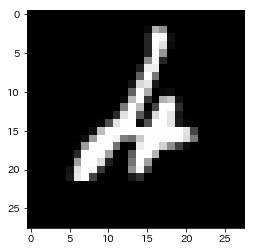

label: 4
predicted label: 6

----------------------------------



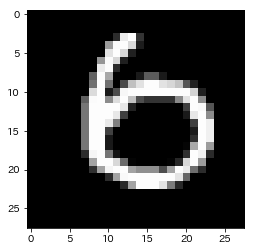

label: 6
predicted label: 0

----------------------------------



In [11]:
# check miss-predicted images
n = 3
for i in range(len(test)):
    x, t = test[i]

    x_deformed = x[None, ...]
    y = model(x_deformed)
    y = y.array

    pred_label = y.argmax(axis=1)
    
    if t != pred_label:
        plt.imshow(x.reshape(28, 28), cmap='gray')
        plt.show()
        print('label:', t)
        print('predicted label:', pred_label[0])
        print('\n----------------------------------\n')
        n -= 1
    
    if n == 0:
        break

---
[Topへ戻る](https://github.com/Kevinrobot34/MLwithPython)